In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.interpolate
import scipy.sparse.linalg 
import scipy.signal

import warnings
warnings.filterwarnings('ignore')

newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
from matplotlib import cm
plt.rcParams.update(newparams)

In [27]:
def create_A(N, a, b, c, x):
    H = np.diff(x)
    A = np.zeros((N,N))
    F = np.zeros(N)
    
    for i in range(len(H)):
        A[i,i] += a/H[i] + c/3 * H[i]
        A[i, i+1] += b/2 - a/H[i] + c/6 * H[i]
        A[i + 1, i] += -b/2 - a/H[i] + c/6 * H[i]
        A[i +1, i+1] += a/H[i] + c/3 * H[i]
    
    A[0,0] = 1
    A[0,1] = 0
    A[N - 1,N - 1] = 1
    A[N - 1,N - 2] = 0
    
    return A

def f_phi_1(x, h, i, f, a, b, c, n = 10000):
    x_int = np.linspace(x[i-1], x[i], n)    
    return f(x_int, a, b, c) * (x_int - np.ones(len(x_int)) * x[i-1]) / h[i], x_int

def f_phi_2(x, h, i, f, a, b, c, n = 10000):
    x_int = np.linspace(x[i], x[i+1], n)
    return  f(x_int, a, b, c) * (x[i+1] * np.ones(len(x_int)) -  x_int) / h[i+1], x_int

def create_F(x, f, a, b, c):
    H_inf = np.concatenate((np.array([np.inf]), np.diff(x)))
    F = np.zeros(len(x))
    for i in range(1, len(x) - 1):
        int_1, x_int_1 = f_phi_1(x, H_inf, i, f, a, b, c)
        int_2, x_int_2 = f_phi_2(x, H_inf, i, f, a, b, c)

        F[i] = scipy.integrate.simps( int_1, x = x_int_1 ) + scipy.integrate.simps( int_2, x = x_int_2 )
    return F

In [28]:
def plot_solutions(x_arr, U_arr, main_title="", sub_titles=[], exact_sol = []):
    # Create the figure and subplots
    fig, axs = plt.subplots(1, len(x_arr), figsize=(20, 4))
    for i in range(len(x_arr)):
        axs[i].plot(x_arr[i],U_arr[i], 'o', label="Numerical")
        
        if len(exact_sol)==len(x_arr):
            #axs[i].plot(x_arr[i],exact_sol[i](x_arr[i]), 'o')
            axs[i].plot(np.linspace(0,1,100), exact_sol[i](np.linspace(0,1,100)), label="Exact")

        if len(sub_titles)==len(x_arr):
            axs[i].set_title(sub_titles[i])

        axs[i].set_xlabel("x")
        axs[i].set_ylabel("u")
        axs[i].legend(loc='upper right')

    # Set the overall title for the figure
    fig.suptitle(main_title)

    # Show the plot
    plt.show()

In [29]:
N = 6
x = np.linspace(0, 1, N)
A = create_A(N, 1, 1, 1, x)
print(A)

[[ 1.          0.          0.          0.          0.          0.        ]
 [-5.46666667 10.13333333 -4.46666667  0.          0.          0.        ]
 [ 0.         -5.46666667 10.13333333 -4.46666667  0.          0.        ]
 [ 0.          0.         -5.46666667 10.13333333 -4.46666667  0.        ]
 [ 0.          0.          0.         -5.46666667 10.13333333 -4.46666667]
 [ 0.          0.          0.          0.          0.          1.        ]]


In [30]:
def f1(x, a, b, c):
    return c * np.exp(-np.pi * x) * np.sin(np.pi * x) + b * np.exp(-np.pi * x) * np.pi * (np.cos(np.pi * x)- np.sin(np.pi * x)) + a * 2 * np.pi**2 * np.exp(-np.pi * x) * np.cos(np.pi * x)
def g1(x):
    return  np.exp(-np.pi * x) * np.sin(np.pi * x) 

a,b,c = 1,1,1
N1 = 20
x1 = np.linspace(0, 1, N1)
A1 = create_A(N1, a, b, c, x1)
F1 = create_F(x1, f1, a, b, c)
U1 = np.linalg.solve(A1, F1)

In [31]:
def f2(x, a, b, c):
    return 2 * a + b * (1 - 2 * x) + c * (x - x**2)

def g2(x):
    return x - x**2

a, b, c = 1, 1, 1
N2 = 20
x2 = np.sort(np.concatenate((np.array((0,1)), np.random.rand(N2-2))))
A2 = create_A(N2, a, b, c, x2)
F2 = create_F(x2, f2, a, b, c)
U2 = np.linalg.solve(A2, F2)

In [32]:
def f3(x,a,b,c):
    return a * 3**2 * np.pi**2 *np.sin(3 * np.pi * x) + b * 3 * np.pi * np.cos(3 * np.pi * x) + c * np.sin(3 * np.pi * x)

def g3(x):
    return np.sin(3 * np.pi * x)

a, b, c = 1, 1, 1
N3 = 20
x3 = np.sort(np.concatenate((np.array((0,1)), np.random.rand(N3-2))))
A3 = create_A(N3, a, b, c, x3)
F3 = create_F(x3, f3, a, b, c)
U3 = np.linalg.solve(A3, F3)

In [33]:
N_test = 1000
x_test = np.linspace(0, 1, N_test)
A_test = create_A(N_test, a, b, c, x_test)
F_test = create_F(x_test, f2, a, b, c)
U_test = np.linalg.solve(A_test, F_test)


# plt.plot(x_test, U_test)
# plt.show()
# plt.plot(x_test, g2(x_test))
# plt.show()
# plt.plot(x_test, U_test - g2(x_test))
# plt.show()

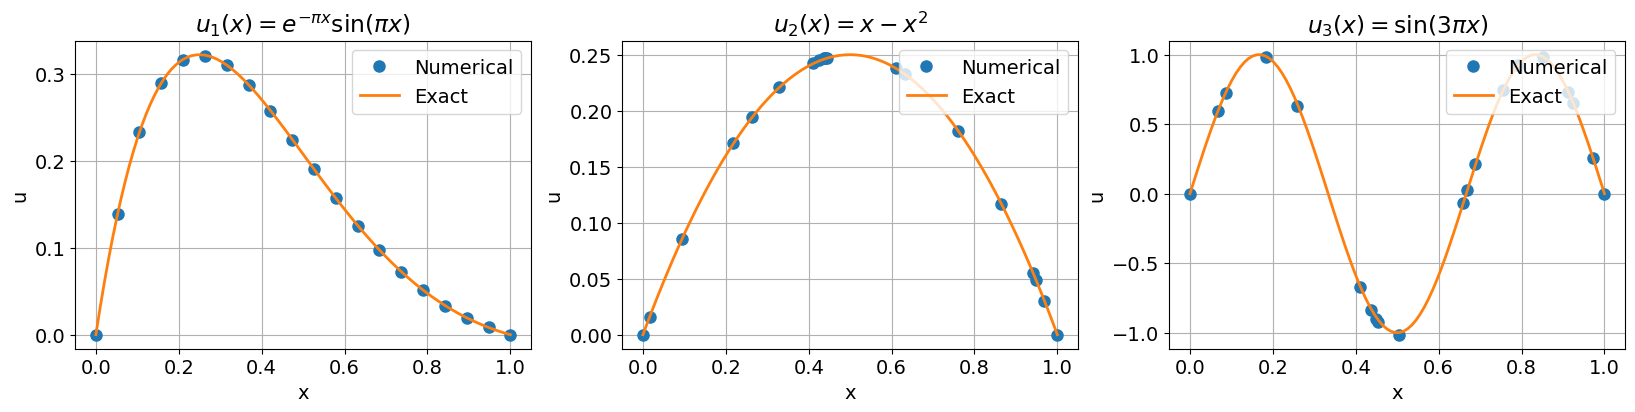

In [34]:
plot_solutions([x1,x2, x3], [U1,U2,U3], main_title="", sub_titles=[r'$u_1(x) = e^{-\pi x} \sin(\pi x) $', r'$u_2(x) = x-x^2$', r'$u_3(x) = \sin(3\pi x)$'], exact_sol = [g1, g2, g3])

In [35]:
def convergence(s, f, g , a = 1, b = 1, c = 1, random = False, plot = False, H1 = False, title = ""):
    E_L2 = np.zeros(s)
    E_H1 = np.zeros(s)
    h_list = np.zeros(s)
    
    for i in range(s):
        N = 100 * 2**(i) 
        x = np.linspace(0,1, N)

        x_ref = np.linspace(0, 1, 1000 * 100*2**s) 

        if random:
            x = np.sort(np.concatenate((np.array((0,1)), np.random.rand(N-2))))
            
        A = create_A(N, a, b, c, x)
        F = create_F(x, f, a, b, c)
        # F = np.roll(F, 1) # Får konvergens 1 med denne.
        U = scipy.sparse.linalg.spsolve(A, F)
        G = g(x)    #Exact solution

        IU = scipy.interpolate.interp1d(x, U, kind='linear')
        error = IU(x_ref) - g(x_ref)

        grad = np.gradient( error, x_ref )

        E_L2[i] = np.sqrt(scipy.integrate.simps((error)**2, x_ref))
        E_H1[i] = np.sqrt(scipy.integrate.simps((error)**2, x_ref) + scipy.integrate.simps((grad)**2, x_ref))

        # U_div = np.gradient(G-U) 
        # # E_L2[i] = (1/N)**(1/2) * np.linalg.norm(G - U, 2 )
        # # E_H1[i] = np.sqrt( E_L2[i]**2  + 1/N * np.linalg.norm(U_div, 2 )**2 )

        # E_L2[i] = np.sqrt(scipy.integrate.simps((G-U)**2, x))
        # E_H1[i] = np.sqrt(scipy.integrate.simps((G-U)**2, x) + scipy.integrate.simps((U_div)**2, x)) 
        # if H1:
        #     U_div = np.gradient(G-U) 
        #     E[i] =  np.sqrt( 1/N * np.linalg.norm(G - U, 2 )**2  + 1/N * np.linalg.norm(U_div, 2 )**2 )
        # else:
        #     # E[i] = np.max(abs(G-U))                                        #Uniform norm
        #     E[i] = (1/N)**(1/2) * np.linalg.norm(G - U, 2 )                 #relation between vector 2 norm an fucntion 2 norm
        
        h_list[i] = 1/N

    # Determining the order using np.polyfit
    order_L2 = np.polyfit(np.log(h_list),np.log(E_L2),1)[0]
    order_H1 = np.polyfit(np.log(h_list),np.log(E_H1),1)[0]

    if plot == True:
        plt.loglog(h_list,E,'o-', label='p={:.3f}'.format(order_L2))
        plt.title(title)
        plt.grid('on')
        plt.xlabel('h')
        plt.ylabel(r'Error')
        plt.legend()
        plt.show()
    
    return E_L2, E_H1, h_list, order_L2, order_H1

In [36]:
x_func = np.linspace(0, 1, 1000)
a, b, c = 1,1,1

func2 = g2(x_func)
func3 = g3(x_func)

E_eq_L2_f2, E_eq_H1_f2, h_list_eq_f2, order_eq_L2_f2, order_eq_H1_f2 = convergence(s = 7, f=f2, g = g2, random = False, plot=False, title="Convergence: Equidistant nodes")
E_ran_L2_f2, E_ran_H1_f2, h_list_ran_f2, order_ran_L2_f2, order_ran_H1_f2 = convergence(s = 7, f=f2, g = g2, random = True, plot=False, title="Convergence: Random nodes")

E_eq_L2_f3, E_eq_H1_f3, h_list_eq_f3, order_eq_L2_f3, order_eq_H1_f3 = convergence(s = 7, f=f3, g = g3, random = False, plot=False, title="Convergence: Equidistant nodes")
E_ran_L2_f3, E_ran_H1_f3, h_list_ran_f3, order_ran_L2_f3, order_ran_H1_f3 = convergence(s = 7, f=f3, g = g3, random = True, plot=False, title="Convergence: Random nodes")

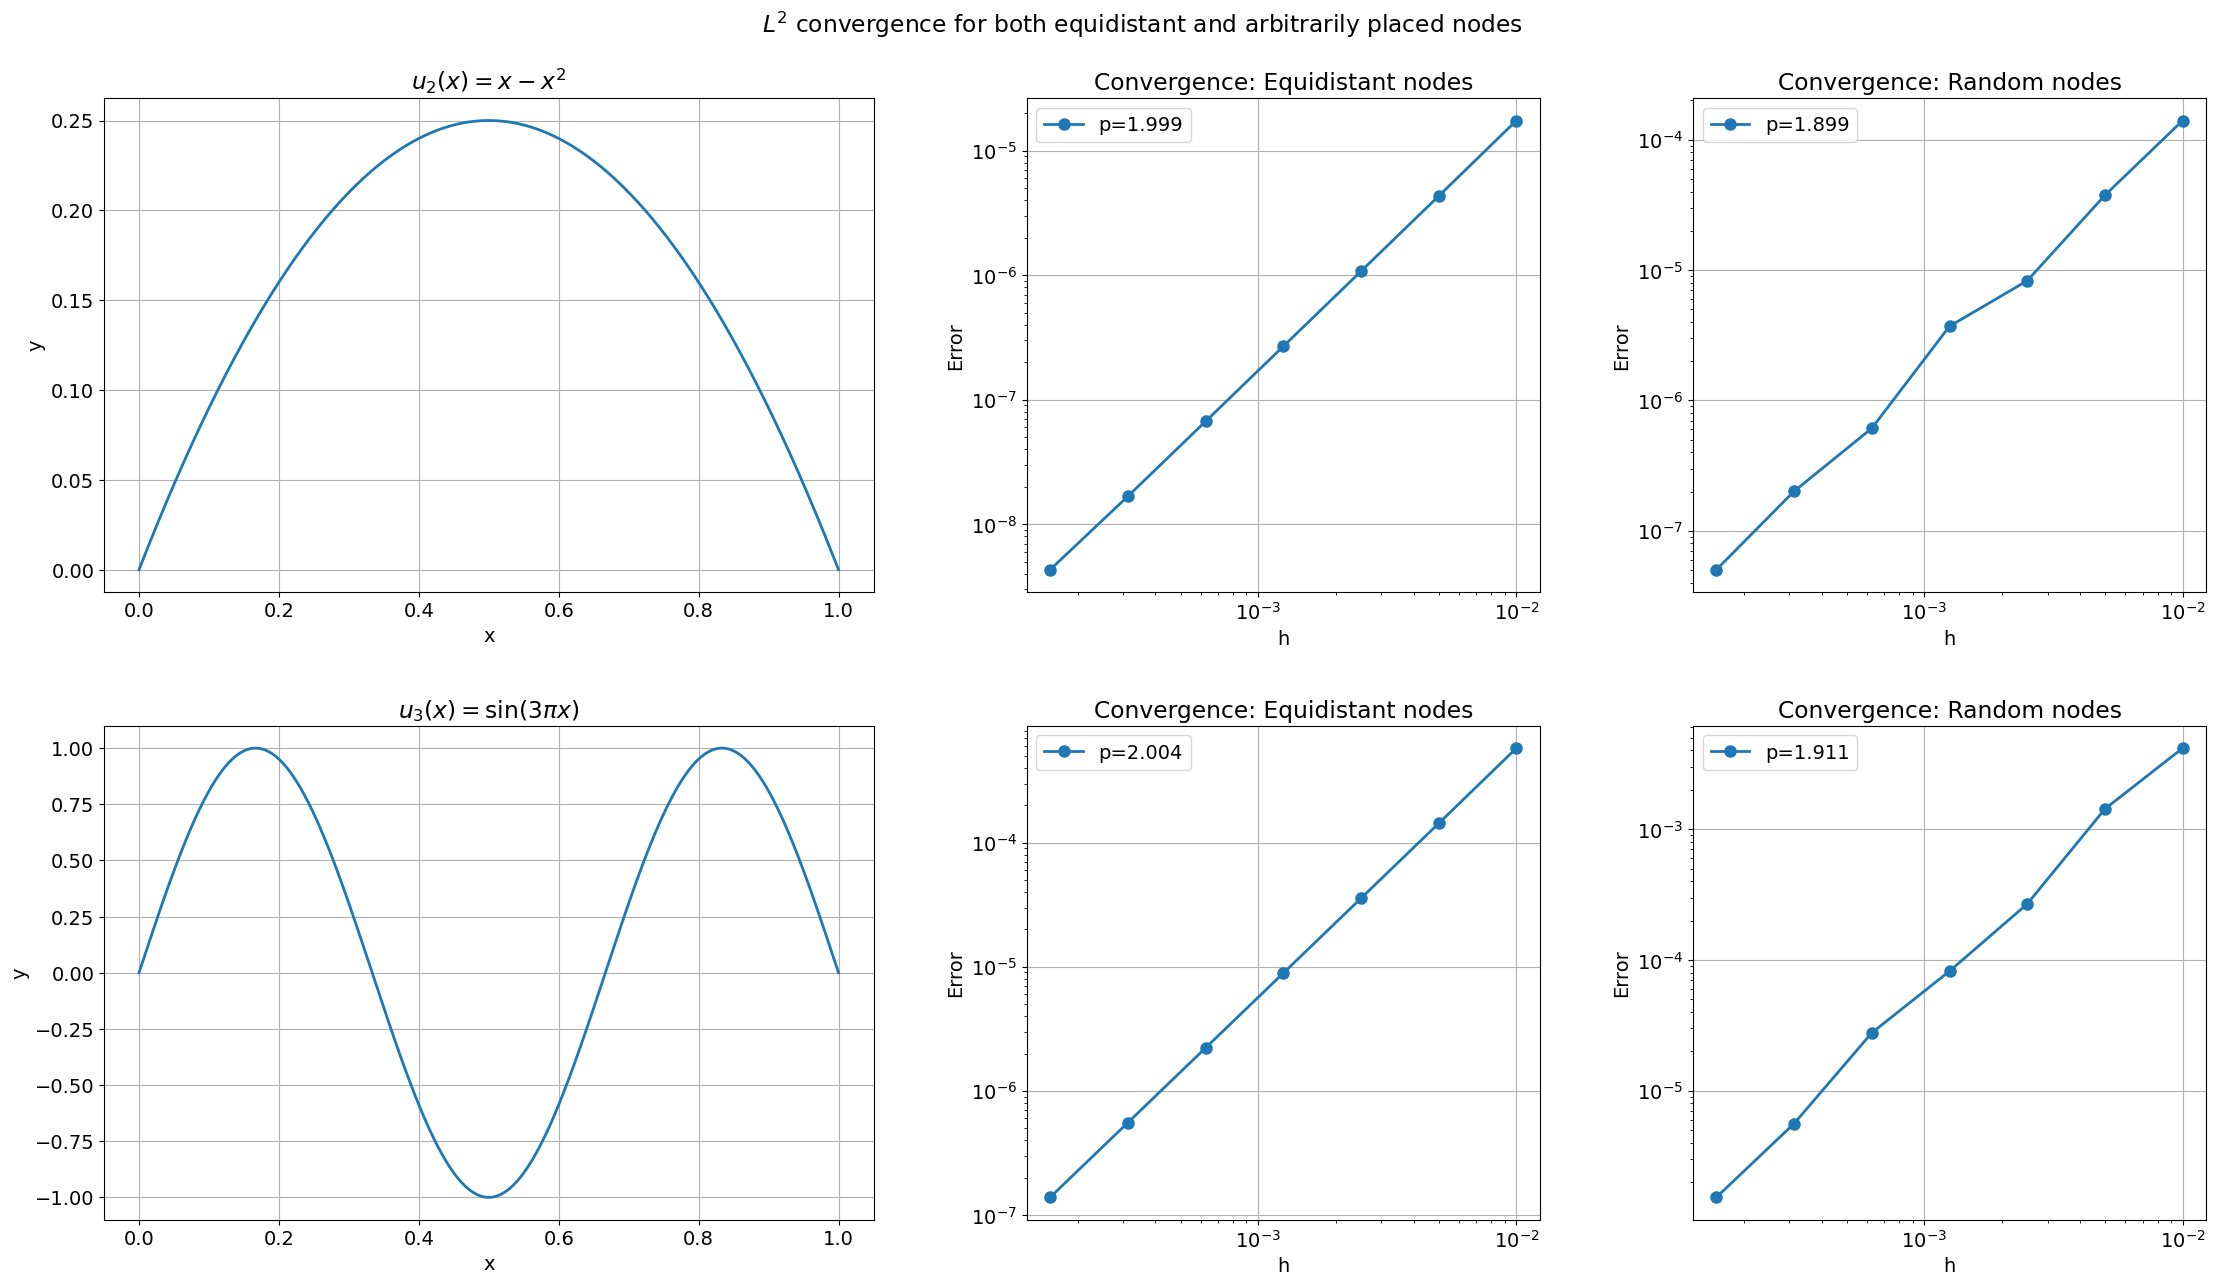

In [37]:
# Create a figure and three subplots in a row
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(22, 12), 
                                        gridspec_kw={'width_ratios': [3/2, 1, 1]})
fig.tight_layout(h_pad=5, w_pad=5)

# Plot the data on each subplot
axs[0, 0].plot(x_func, func2)
axs[0, 0].set_title(r'$u_2(x) = x - x^2$')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')

axs[0, 1].loglog(h_list_eq_f2,E_eq_L2_f2,'o-', label='p={:.3f}'.format(order_eq_L2_f2))
axs[0, 1].set_title('Convergence: Equidistant nodes')
axs[0, 1].grid('on')
axs[0, 1].set_xlabel('h')
axs[0, 1].set_ylabel(r'Error')
axs[0, 1].legend()

axs[0, 2].loglog(h_list_ran_f2,E_ran_L2_f2,'o-', label='p={:.3f}'.format(order_ran_L2_f2))
axs[0, 2].set_title('Convergence: Random nodes')
axs[0, 2].grid('on')
axs[0, 2].set_xlabel('h')
axs[0, 2].set_ylabel(r'Error')
axs[0, 2].legend()

axs[1, 0].plot(x_func, func3)
axs[1, 0].set_title(r'$u_3(x) = \sin(3 \pi x)$')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')

axs[1, 1].loglog(h_list_eq_f3,E_eq_L2_f3,'o-', label='p={:.3f}'.format(order_eq_L2_f3))
axs[1, 1].set_title('Convergence: Equidistant nodes')
axs[1, 1].grid('on')
axs[1, 1].set_xlabel('h')
axs[1, 1].set_ylabel(r'Error')
axs[1, 1].legend()

axs[1, 2].loglog(h_list_ran_f3,E_ran_L2_f3,'o-', label='p={:.3f}'.format(order_ran_L2_f3))
axs[1, 2].set_title('Convergence: Random nodes')
axs[1, 2].grid('on')
axs[1, 2].set_xlabel('h')
axs[1, 2].set_ylabel(r'Error')
axs[1, 2].legend()

# Add a title for the entire figure
fig.suptitle(r'$L^2$ convergence for both equidistant and arbitrarily placed nodes', y = 1.05)

# Display the figure
plt.show()

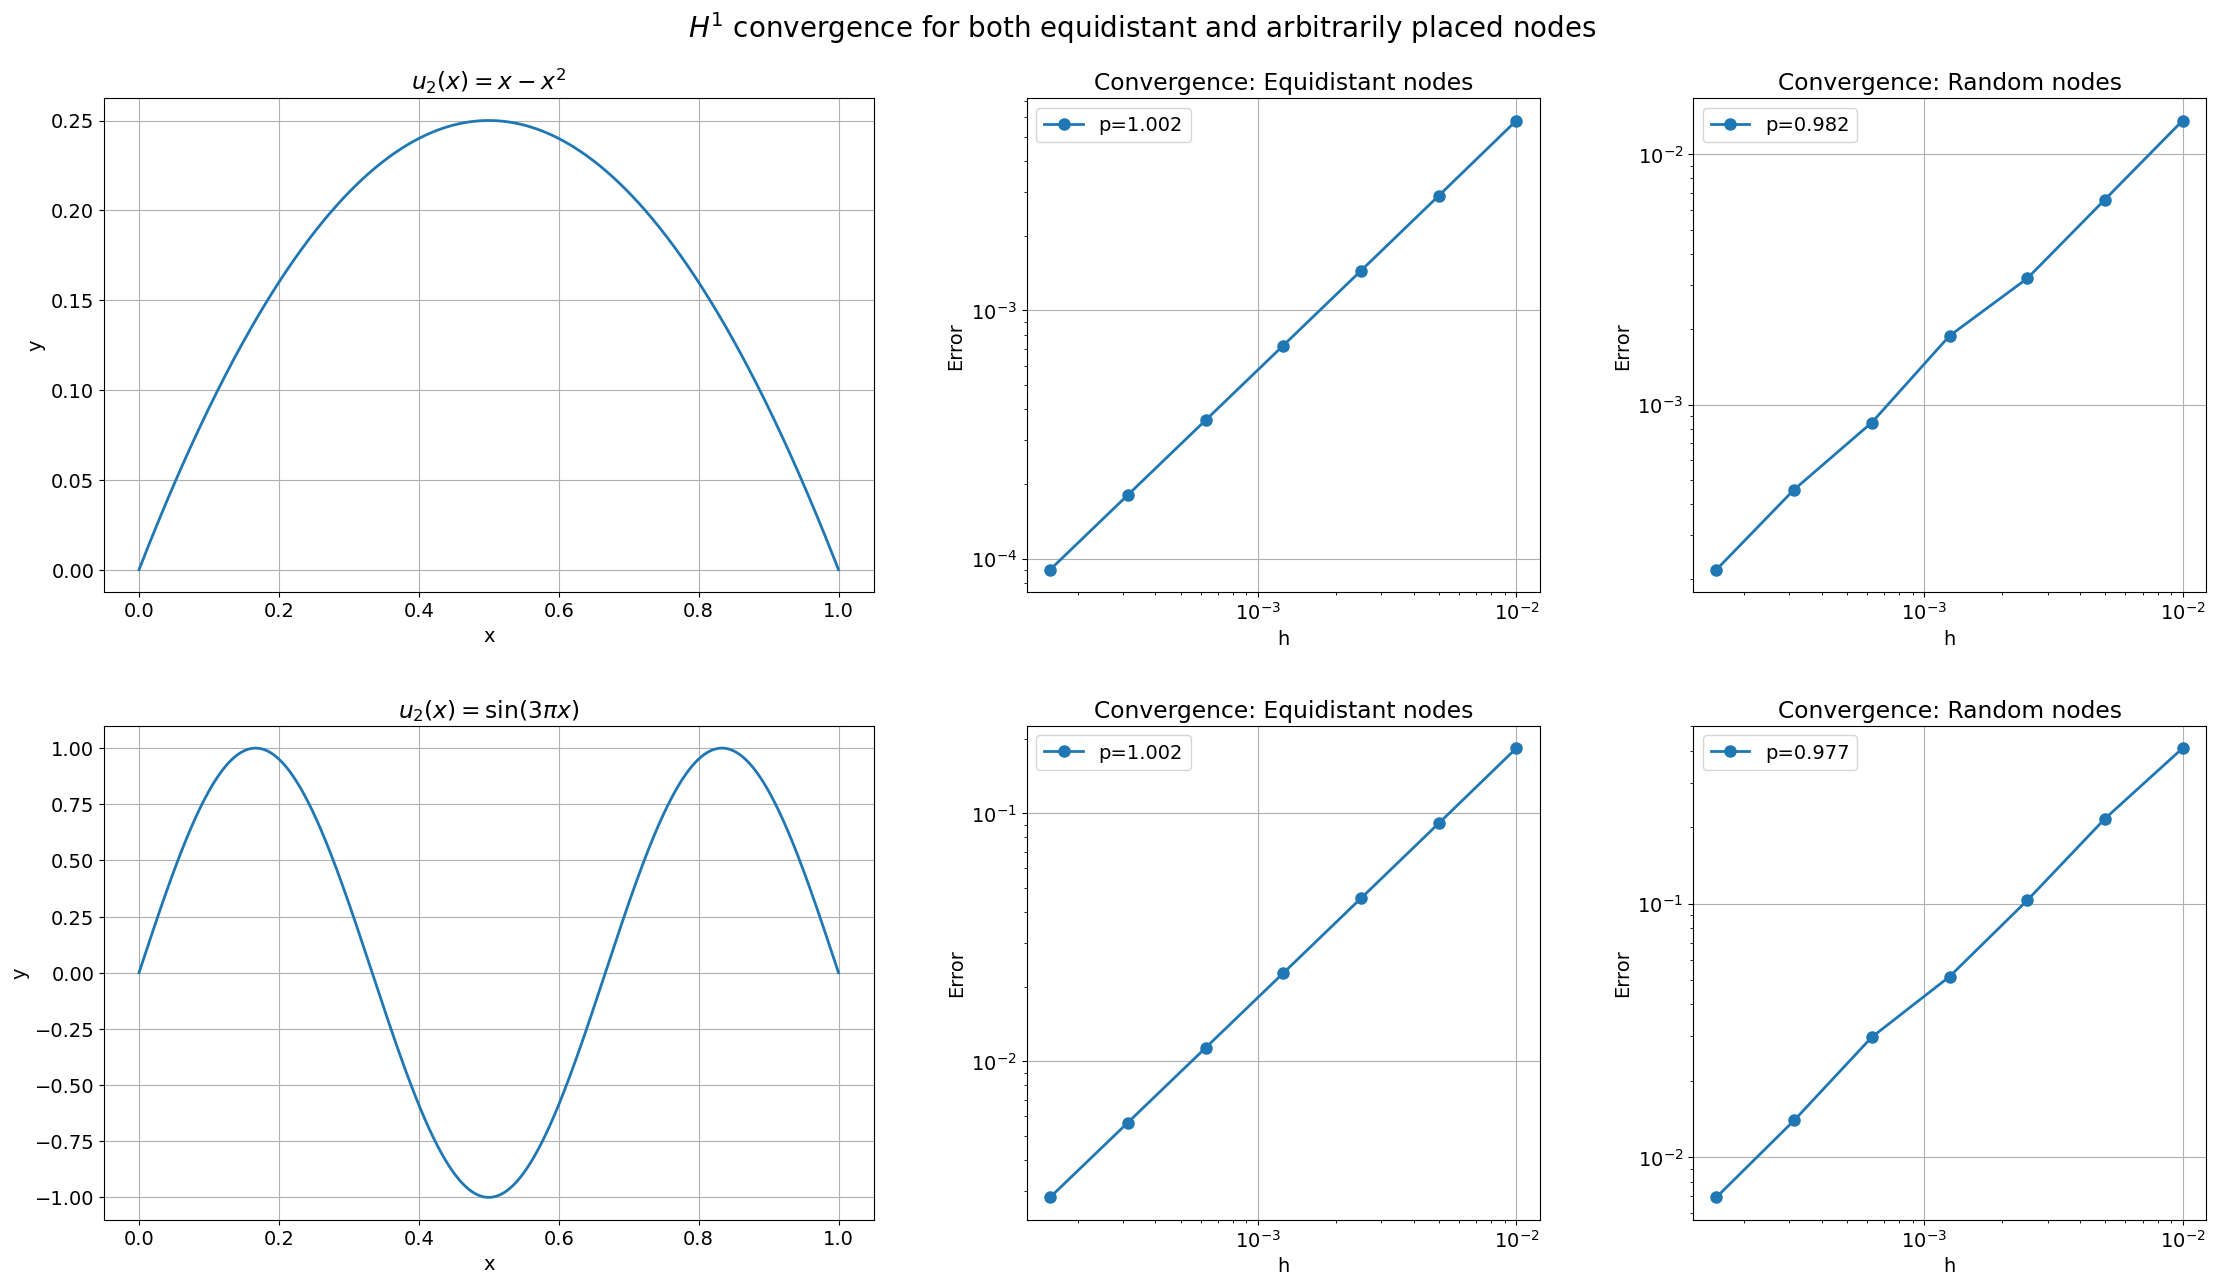

In [38]:
# Create a figure and three subplots in a row
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(22, 12), 
                                        gridspec_kw={'width_ratios': [3/2, 1, 1]})
fig.tight_layout(h_pad=5, w_pad=5)

# Plot the data on each subplot
axs[0, 0].plot(x_func, func2)
axs[0, 0].set_title(r'$u_2(x) = x - x^2$')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')

axs[0, 1].loglog(h_list_eq_f2,E_eq_H1_f2,'o-', label='p={:.3f}'.format(order_eq_H1_f2))
axs[0, 1].set_title('Convergence: Equidistant nodes')
axs[0, 1].grid('on')
axs[0, 1].set_xlabel('h')
axs[0, 1].set_ylabel(r'Error')
axs[0, 1].legend()

axs[0, 2].loglog(h_list_ran_f2,E_ran_H1_f2,'o-', label='p={:.3f}'.format(order_ran_H1_f2))
axs[0, 2].set_title('Convergence: Random nodes')
axs[0, 2].grid('on')
axs[0, 2].set_xlabel('h')
axs[0, 2].set_ylabel(r'Error')
axs[0, 2].legend()

axs[1, 0].plot(x_func, func3)
axs[1, 0].set_title(r'$u_2(x) = \sin(3 \pi x)$')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')

axs[1, 1].loglog(h_list_eq_f3, E_eq_H1_f3,'o-', label='p={:.3f}'.format(order_eq_H1_f3))
axs[1, 1].set_title('Convergence: Equidistant nodes')
axs[1, 1].grid('on')
axs[1, 1].set_xlabel('h')
axs[1, 1].set_ylabel(r'Error')
axs[1, 1].legend()

axs[1, 2].loglog(h_list_ran_f3,E_ran_H1_f3,'o-', label='p={:.3f}'.format(order_ran_H1_f3))
axs[1, 2].set_title('Convergence: Random nodes')
axs[1, 2].grid('on')
axs[1, 2].set_xlabel('h')
axs[1, 2].set_ylabel(r'Error')
axs[1, 2].legend()

# Add a title for the entire figure
fig.suptitle(r'$H^1$ convergence for both equidistant and arbitrarily placed nodes', y = 1.05, fontsize = 20)

# Display the figure
plt.show()

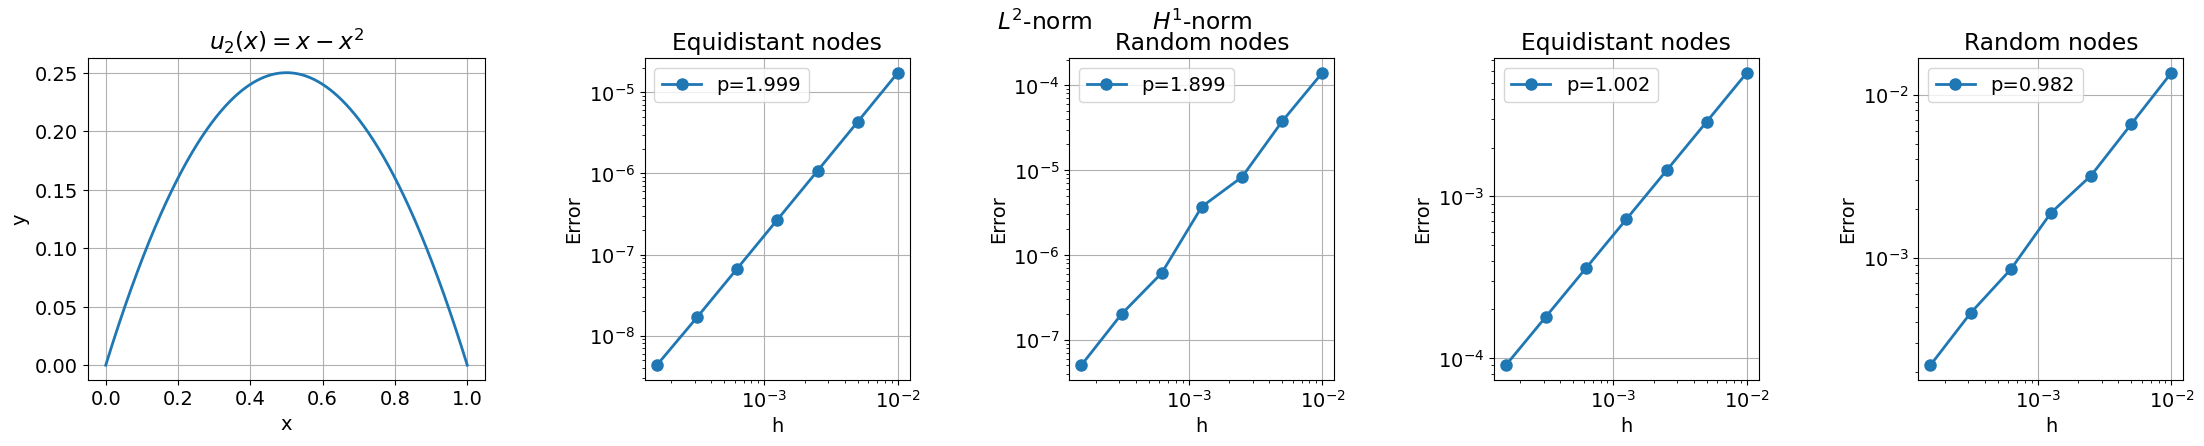

In [39]:

# Create a figure and three subplots in a row
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(22, 4), 
                                        gridspec_kw={'width_ratios': [3/2, 1, 1, 1, 1]})
fig.tight_layout(h_pad=5, w_pad=5)

# Plot the data on each subplot
axs[0].plot(x_func, func2)
axs[0].set_title(r'$u_2(x) = x - x^2$')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

axs[1].loglog(h_list_eq_f2,E_eq_L2_f2,'o-', label='p={:.3f}'.format(order_eq_L2_f2))
axs[1].set_title('Equidistant nodes')
axs[1].grid('on')
axs[1].set_xlabel('h')
axs[1].set_ylabel(r'Error')
axs[1].legend()

axs[2].loglog(h_list_ran_f2,E_ran_L2_f2,'o-', label='p={:.3f}'.format(order_ran_L2_f2))
axs[2].set_title('Random nodes')
axs[2].grid('on')
axs[2].set_xlabel('h')
axs[2].set_ylabel(r'Error')
axs[2].legend()

axs[3].loglog(h_list_eq_f2,E_eq_H1_f2,'o-', label='p={:.3f}'.format(order_eq_H1_f2))
axs[3].set_title('Equidistant nodes')
axs[3].grid('on')
axs[3].set_xlabel('h')
axs[3].set_ylabel(r'Error')
axs[3].legend()

axs[4].loglog(h_list_ran_f2,E_ran_H1_f2,'o-', label='p={:.3f}'.format(order_ran_H1_f2))
axs[4].set_title('Random nodes')
axs[4].grid('on')
axs[4].set_xlabel('h')
axs[4].set_ylabel(r'Error')
axs[4].legend()


# Add a title for the entire figure
# fig.suptitle(r'$L^2$ convergence for both equidistant and arbitrarily placed nodes', y = 1.05)
fig.suptitle(r'$L^2$-norm        $H^1$-norm ', y = 1.05)

# Display the figure
plt.show()

In [40]:
def dw1(x):
    x_first = x[ x < 1/2]
    x_second = x[x >= 1/2]
    dw1 = np.concatenate( (2 * np.ones_like(x_first), -2 * np.ones_like(x_second)) )
    return dw1

def w1(x):
    return np.concatenate( (2 * x[ x < 1/2 ], 2*(1 - x[ x >= 1/2 ])) ) 

def fw1(x, a, b, c, dw = dw1, w = w1):
    return  b * dw(x) + c * w(x)

In [41]:
def dw2(x):
    return 1 - 2/3 * x**(-1/3)

def w2(x):
    return x - x**(2/3) 

def fw2(x, a, b, c, dw = dw2, w = w2):
    return  b * dw(x) + c * w(x)

In [42]:
def create_F_w(x, a, b, c,  w = w1, f = fw1):
    H_inf = np.concatenate((np.array([np.inf]), np.diff(x)))
    F = np.zeros(len(x))
    for i in range(1, len(x) - 1):
        int_1, x_int_1 = f_phi_1(x, H_inf, i, f, a, b, c)
        int_2, x_int_2 = f_phi_2(x, H_inf, i, f, a, b, c)        

        F[i] = - a * ( w(x[i-1])/H_inf[i] + w(x[i+1])/H_inf[i+1] - w(x[i]) * (1/H_inf[i] + 1/H_inf[i+1]) ) + scipy.integrate.simps( int_1, x = x_int_1 ) + scipy.integrate.simps( int_2, x = x_int_2 )
        # F[i] = - a * ( w(x[i-1])/H_inf[i] - w(x[i+1])/H_inf[i+1] - w(x[i]) * (1/H_inf[i] - 1/H_inf[i+1]) ) + scipy.integrate.simps( int_1, x = x_int_1 ) + scipy.integrate.simps( int_2, x = x_int_2 )
    return F 

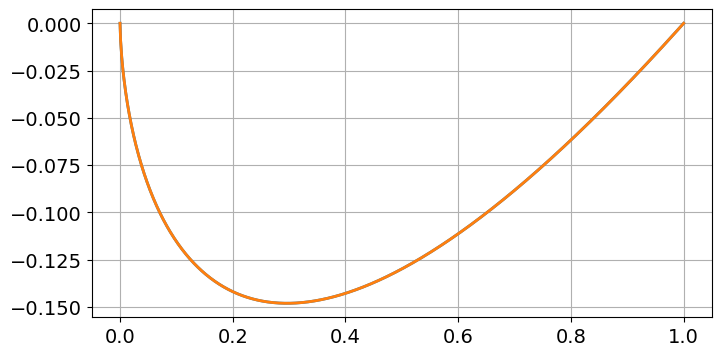

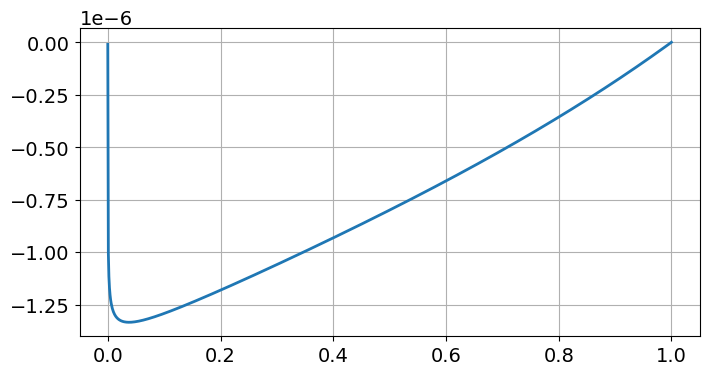

In [43]:
N = 1001
a, b, c = 1, 1, 1
x = np.linspace(1e-12,1,N)

A_test = create_A(N, a, b, c, x)
F_test = create_F_w(x, a, b, c, w2, fw2)
U_test = np.linalg.solve(A_test, F_test)

plt.plot(x, U_test)
plt.plot(x, w2(x))
plt.show()
plt.plot(x, w2(x)-U_test)
plt.show()

In [44]:
N = 1000
a, b, c = 1, 1, 1
x = np.linspace(1e-12,1,N)

A_test = create_A(N, a, b, c, x)
F_test = create_F_w(x, a, b, c, w2, fw2)
U_test = np.linalg.solve(A_test, F_test)

# plt.plot(x, U_test, 'o')
# plt.plot(x, w2(x))
# plt.show()
# plt.plot(x, w2(x)-U_test)

In [45]:
def convergence_w(s = 7, fw = fw1, w = w1, a = 1, b = 1, c = 1, random = False, plot = False, H1 = False, title = ""):
    # E = np.zeros(s)
    E_L2 = np.zeros(s)
    E_H1 = np.zeros(s)
    h_list = np.zeros(s)
    
    for i in range(s):
        N = 100 * 2**(i) + 1 # 1 ordens konvergens
        # N = 100 * 2**(i) # 2. ordens konvergens
        x = np.linspace(1e-20,1,N)
        x_ref = np.linspace(1e-20, 1, 1000 * 100*2**s+1) 

        if random:
            x = np.sort(np.concatenate((np.array((0,1)), np.random.rand(N-2))))
            
        A = create_A(N, a, b, c, x)
        F = create_F_w(x, a, b, c, w, fw)
        U = scipy.sparse.linalg.spsolve(A, F)
        G = w(x)    #Exact solution


        IU = scipy.interpolate.interp1d(x, U, kind='linear')
        error = IU(x_ref) - w(x_ref)

        grad = np.gradient( error, x_ref )

        E_L2[i] = np.sqrt(scipy.integrate.simps((error)**2, x_ref))
        E_H1[i] = np.sqrt(scipy.integrate.simps((error)**2, x_ref) + scipy.integrate.simps((grad)**2, x_ref))


        # U_div = np.gradient(G-U, x)
        # # E_L2[i] =  (1/N)**(1/2) * np.linalg.norm( G - U, 2 )     
        # # E_H1[i] = np.sqrt( E_L2[i]**2 + 1/N * np.linalg.norm( U_div, 2 )**2 )


        # E_L2[i] = np.sqrt(scipy.integrate.simps((G-U)**2, x))
        # E_H1[i] = np.sqrt( scipy.integrate.simps((G-U)**2, x) +  scipy.integrate.simps((U_div)**2, x)) 

        # if H1:
        #     U_div = np.gradient(G-U, x)
        #     # print('diff', (np.linalg.norm( U_div, 2 )**2)**(1/2) ) 
        #     # print('ikke diff', np.linalg.norm( G - U, 2 ))
        #     E[i] =  np.sqrt( 1/N * np.linalg.norm( G - U, 2 )**2  + 1/N * np.linalg.norm( U_div, 2 )**2 )
        # else:
        #     # E[i] = np.max(abs(G-U))                                        #Uniform norm
        #     E[i] = (1/N)**(1/2) * np.linalg.norm( G - U, 2 )                 #relation between vector 2 norm an fucntion 2 norm
            
        
        h_list[i] = 1/N

    # Determining the order using np.polyfit
    order_L2 = np.polyfit(np.log(h_list),np.log(E_L2),1)[0]
    order_H1 = np.polyfit(np.log(h_list),np.log(E_H1),1)[0]

    if plot == True:
        plt.loglog(h_list,E,'o-', label='p={:.3f}'.format(order_L2))
        plt.title(title)
        plt.grid('on')
        plt.xlabel('h')
        plt.ylabel(r'Error')
        plt.legend()
        plt.show()
    
    return E_L2, E_H1, h_list, order_L2, order_H1

In [46]:
x_func = np.linspace(0, 1, 1000)
a, b, c = 1,1,1

w1_func = w1(x_func)
w2_func = w2(x_func)

E_eq_L2_w1, E_eq_H1_w1, h_list_eq_w1, order_eq_L2_w1, order_eq_H1_w1 = convergence_w(s = 7, fw=fw1, w = w1, random = False, plot=False, title="Convergence: Equidistant nodes")
E_eq_L2_w2, E_eq_H1_w2, h_list_eq_w2, order_eq_L2_w2, order_eq_H1_w2 = convergence_w(s = 7, fw=fw2, w = w2, random = False, plot=False, title="Convergence: Equidistant nodes")

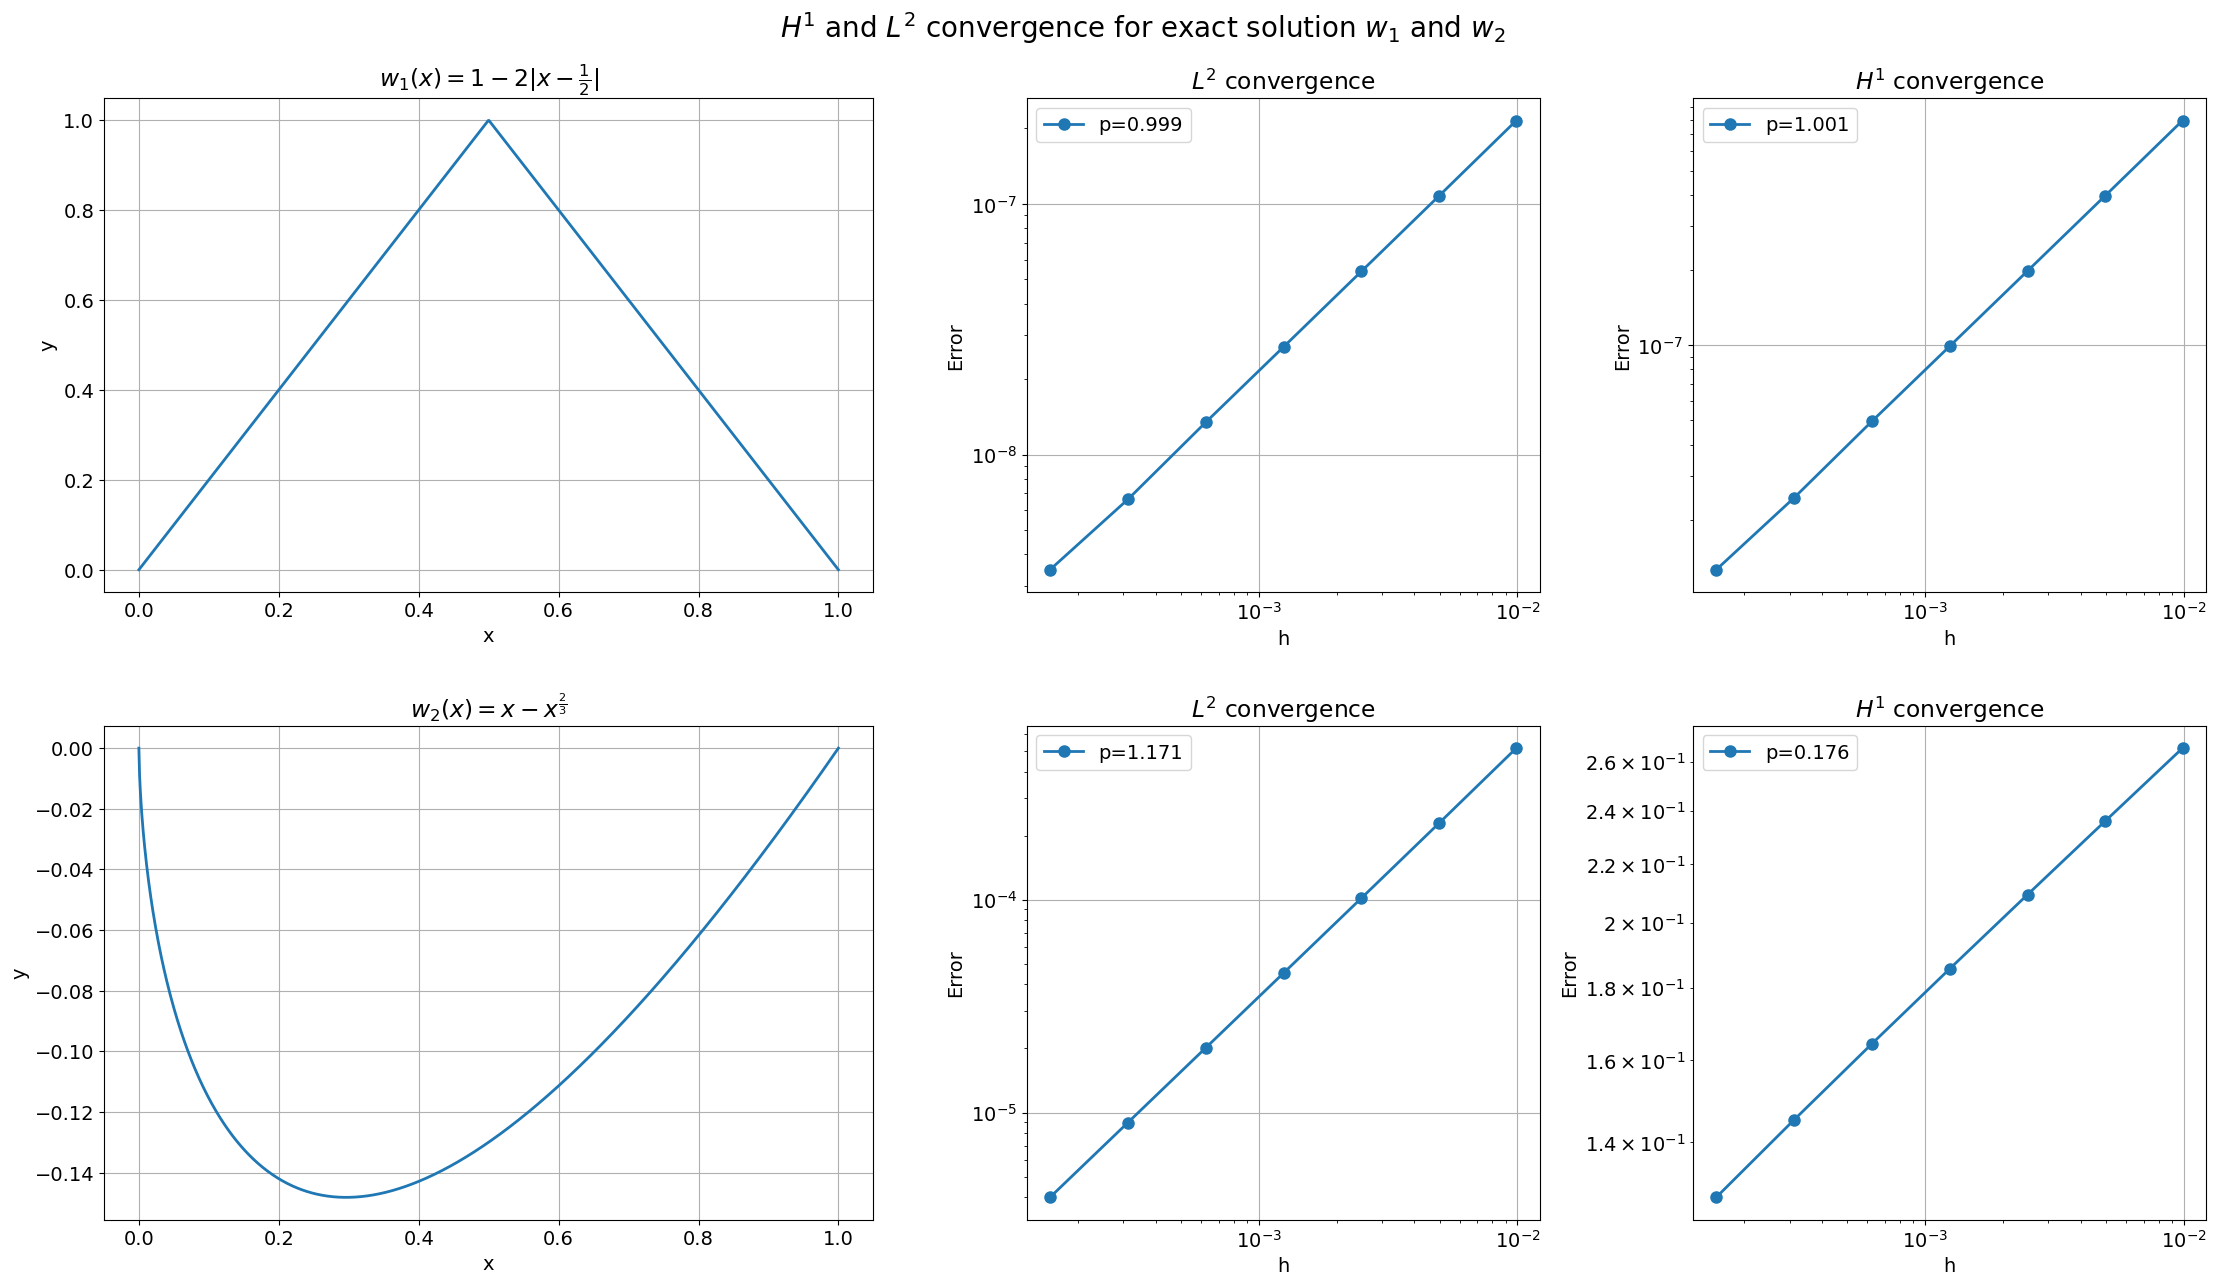

In [47]:
# Create a figure and three subplots in a row
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(22, 12), 
                                        gridspec_kw={'width_ratios': [3/2, 1, 1]})
fig.tight_layout(h_pad=5, w_pad=5)

# Plot the data on each subplot
axs[0, 0].plot(x_func, w1_func)
axs[0, 0].set_title(r'$w_1(x) = 1 - 2|x-\frac{1}{2}|$')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')

axs[0, 1].loglog(h_list_eq_w1,E_eq_L2_w1,'o-', label='p={:.3f}'.format(order_eq_L2_w1))
axs[0, 1].set_title(r'$L^2$ convergence')
axs[0, 1].grid('on')
axs[0, 1].set_xlabel('h')
axs[0, 1].set_ylabel(r'Error')
axs[0, 1].legend()

axs[0, 2].loglog(h_list_eq_w1,E_eq_H1_w1,'o-', label='p={:.3f}'.format(order_eq_H1_w1))
axs[0, 2].set_title(r'$H^1$ convergence')
axs[0, 2].grid('on')
axs[0, 2].set_xlabel('h')
axs[0, 2].set_ylabel(r'Error')
axs[0, 2].legend()

axs[1, 0].plot(x_func, w2_func)
axs[1, 0].set_title(r'$w_2(x) = x - x^{\frac{2}{3}}$')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')

axs[1, 1].loglog(h_list_eq_w2,E_eq_L2_w2,'o-', label='p={:.3f}'.format(order_eq_L2_w2))
axs[1, 1].set_title(r'$L^2$ convergence')
axs[1, 1].grid('on')
axs[1, 1].set_xlabel('h')
axs[1, 1].set_ylabel(r'Error')
axs[1, 1].legend()

axs[1, 2].loglog(h_list_eq_w2,E_eq_H1_w2,'o-', label='p={:.3f}'.format(order_eq_H1_w2))
axs[1, 2].set_title(r'$H^1$ convergence')
axs[1, 2].grid('on')
axs[1, 2].set_xlabel('h')
axs[1, 2].set_ylabel(r'Error')
axs[1, 2].legend()

# Add a title for the entire figure
fig.suptitle(r'$H^1$ and $L^2$ convergence for exact solution $w_1$ and $w_2$', y = 1.05, fontsize = 20)

# Display the figure
plt.show()

In [ ]:
# Create a figure and three subplots in a row
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(22, 12), 
                                        gridspec_kw={'width_ratios': [3/2, 1, 1, 3/2, 1, 1]})
fig.tight_layout(h_pad=5, w_pad=5)

# Plot the data on each subplot
axs[0, 0].plot(x_func, w1_func)
axs[0, 0].set_title(r'$w_1(x) = 1 - 2|x-\frac{1}{2}|$')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
axs[0, 1].loglog(h_list_eq_w1,E_eq_L2_w1,'o-', label='p={:.3f}'.format(order_eq_L2_w1))
axs[0, 1].set_title(r'$L^2$ convergence')
axs[0, 1].grid('on')
axs[0, 1].set_xlabel('h')
axs[0, 1].set_ylabel(r'Error')
axs[0, 1].legend()
axs[0, 2].loglog(h_list_eq_w1,E_eq_H1_w1,'o-', label='p={:.3f}'.format(order_eq_H1_w1))
axs[0, 2].set_title(r'$H^1$ convergence')
axs[0, 2].grid('on')
axs[0, 2].set_xlabel('h')
axs[0, 2].set_ylabel(r'Error')
axs[0, 2].legend()
axs[1, 0].plot(x_func, w2_func)
axs[1, 0].set_title(r'$w_2(x) = x - x^{\frac{2}{3}}$')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')
axs[1, 1].loglog(h_list_eq_w2,E_eq_L2_w2,'o-', label='p={:.3f}'.format(order_eq_L2_w2))
axs[1, 1].set_title(r'$L^2$ convergence')
axs[1, 1].grid('on')
axs[1, 1].set_xlabel('h')
axs[1, 1].set_ylabel(r'Error')
axs[1, 1].legend()

axs[1, 2].loglog(h_list_eq_w2,E_eq_H1_w2,'o-', label='p={:.3f}'.format(order_eq_H1_w2))
axs[1, 2].set_title(r'$H^1$ convergence')
axs[1, 2].grid('on')
axs[1, 2].set_xlabel('h')
axs[1, 2].set_ylabel(r'Error')
axs[1, 2].legend()

# Add a title for the entire figure
fig.suptitle(r'$H^1$ and $L^2$ convergence for exact solution $w_1$ and $w_2$', y = 1.05, fontsize = 20)

# Display the figure
plt.show()

In [48]:
# a, b, c = 1, -8, 33
# def f_e(x, a, b, c):
#     return abs(x)**(-1/4)

# epsilon = 1e-12

# N_ref = 2**16
# x_ref = np.linspace(epsilon, 1, N_ref)

# # x_ref = 10/9 * np.logspace(0, 1, N_ref)/10 - 1/9

# A_ref = create_A(N_ref, a, b, c, x_ref)
# F_ref = create_F(x_ref, f_e, a, b, c)
# U_ref = scipy.sparse.linalg.spsolve(A_ref, F_ref)

# #print(F_ref)
# #print(U_ref)

In [49]:
a, b, c = 1, -100, 100**2

def f_e(x, a, b, c):
    return 1

epsilon = 1e-12

N_ref = 2**16
x_ref = np.linspace(epsilon, 1, N_ref)

# x_ref = 10/9 * np.logspace(0, 1, N_ref)/10 - 1/9

A_ref = create_A(N_ref, a, b, c, x_ref)
F_ref = create_F(x_ref, f_e, a, b, c)
U_ref = scipy.sparse.linalg.spsolve(A_ref, F_ref)

#print(F_ref)
#print(U_ref)

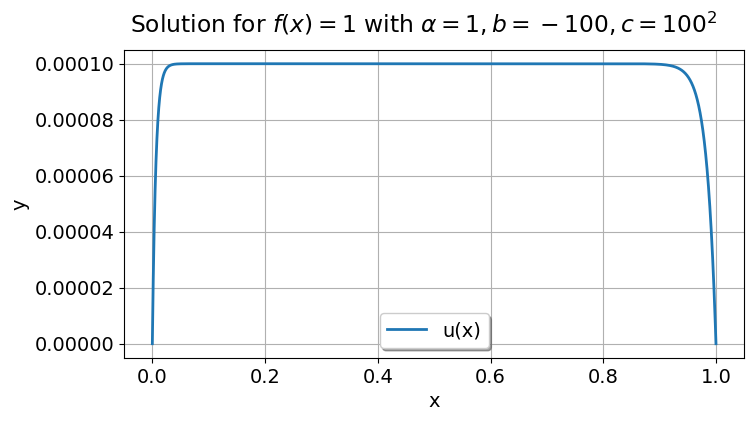

In [50]:
fig = plt.figure()
fig.suptitle(r'Solution for $f(x) = 1$ with $\alpha = 1, b =-100, c = 100^2$')
plt.plot(x_ref, U_ref, label = 'u(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(shadow= True, fancybox = True, loc = 'lower center')
plt.show()

In [51]:
print(len(A_ref))

65536


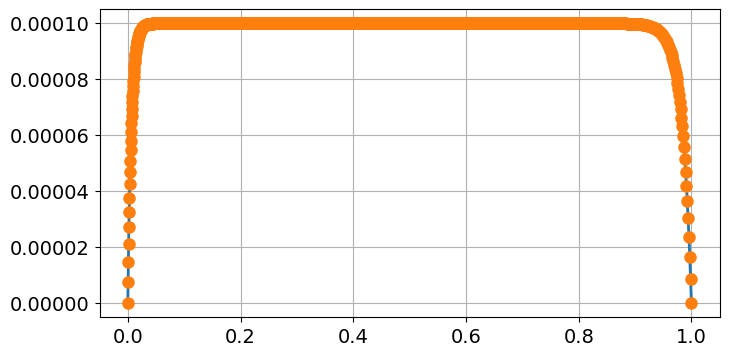

In [52]:
N_test = 2**10
a, b, c = 1, -100, 100**2
# a, b, c = 1, -8, 33
# x_test_log = np.concatenate( (np.linspace(0, 1/4, N_test_log //2), np.linspace(1/4, 1, N_test_log//2)) )
x_test_log = np.concatenate( (np.linspace(1e-12, 1/4, N_test//2, endpoint = False), np.linspace(1/4, 1, N_test//2, endpoint = True)) )

A_test_log = create_A(N_test, a, b, c, x_test_log)
F_test_log = create_F(x_test_log, f_e, a, b, c)
U_test_log = scipy.sparse.linalg.spsolve(A_test_log, F_test_log)

# print(F_test_log)
# print(x_test_log)
# print(U_test_log)

plt.plot(x_ref, U_ref)
plt.plot(x_test_log, U_test_log, 'o')
plt.show()

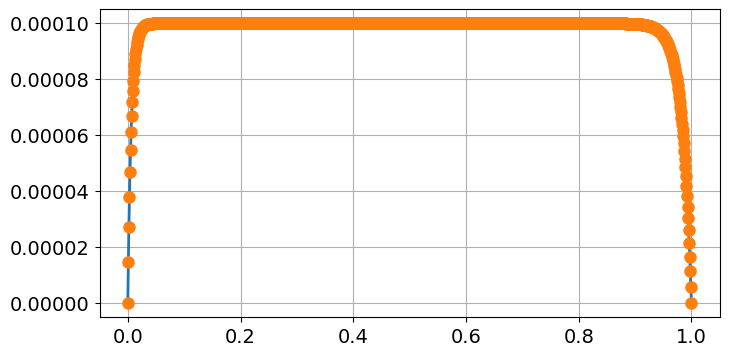

In [53]:
a, b, c = 1, -100, 100**2
# a, b, c = 1, -8, 33
x_test = np.linspace(1e-12, 1, N_test)

A_test = create_A(N_test, a, b, c, x_test)
F_test = create_F(x_test, f_e, a, b, c)
U_test = scipy.sparse.linalg.spsolve(A_test, F_test)

plt.plot(x_ref, U_ref)
plt.plot(x_test, U_test, 'o')
plt.show()

In [54]:
def error(u, x, U_ref = U_ref, x_ref = x_ref):
    Iu = np.interp(x_ref, x, u)
    error = U_ref - Iu
    return error, x_ref

In [55]:
def L2(error, x):
    H = np.concatenate( (np.array( [0] ), np.diff(x)) )
    return np.sqrt( np.inner( H, abs(error)**2 ) )

In [56]:
def H1(error, x):
    print(scipy.integrate.simps(( np.gradient(error) )**2, x))
    E = np.sqrt( scipy.integrate.simps((error)**2, x) +  scipy.integrate.simps(( np.gradient(error) )**2, x)) 
    return E

In [57]:
def diff_with_ref(U_ref, U, noneq = True):
    if noneq == False:
        return 

    M = np.log2( len(U_ref) ) 
    k = np.log2( len(U) )
    
    first = ( U_ref[:len(U_ref) // 4] )[::int(2**(M - k - 1))] - U[:len(U) // 2]
    second = ( U_ref[len(U_ref) // 4:] )[::int(3* 2**(M - k - 1))] - U[len(U)//2:]

    return np.concatenate( (first, second) )

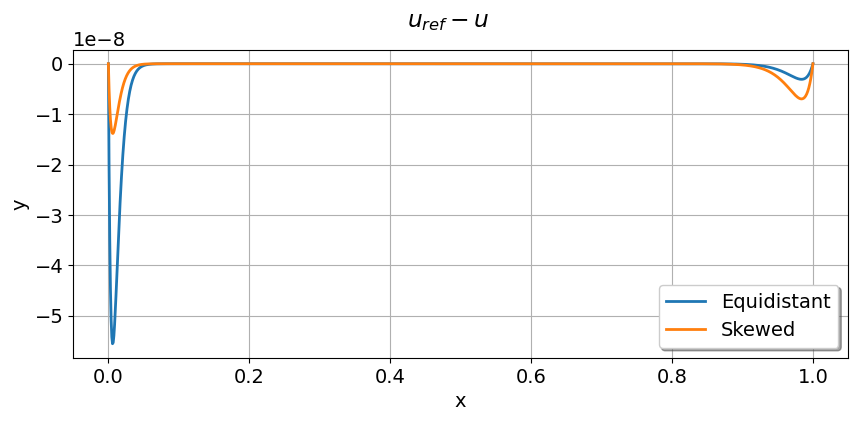

In [58]:
func = scipy.interpolate.interp1d(x_ref, U_ref, kind = 'linear')
error_tony = func(x_test) - U_test
error_thor = func(x_test_log) - U_test_log

# print(L2(error_tony, x_test))
# print(L2(error_thor, x_test_log))

fig = plt.figure(figsize = (10,4))
fig.suptitle(r'$u_{ref} - u$')
plt.plot(x_test, error_tony, label = 'Equidistant')
plt.plot(x_test_log, error_thor, label = 'Skewed')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(fancybox = True, shadow = True, loc = 'lower right')
plt.show()

In [59]:
def pain(number, start, H1_true = False):
    # a, b, c = 1, -8, 33
    a, b, c = 1, -100, 100**2
    E_test = np.zeros(number)
    E_test_log = np.zeros(number)
    N_array = np.zeros(number)

    for i in range(number):
        N_test = 2**(start + i)
        x_test_log = np.concatenate( (np.linspace(0, 1/4, N_test//2 , endpoint = False), np.linspace(1/4, 1, N_test//2 , endpoint = True)) )
        x_test_log[0] = 1e-12
        
        A_test_log = create_A(N_test, a, b, c, x_test_log)
        F_test_log = create_F(x_test_log, f_e, a, b, c)
        U_test_log = scipy.sparse.linalg.spsolve(A_test_log, F_test_log)

        x_test = np.linspace(0, 1, N_test)
        x_test[0] = 1e-12
        x_ref = np.linspace(0, 1, 1000 * 100*2**number) 
        x_ref[0] =1e-12

        A_test = create_A(N_test, a, b, c, x_test)
        F_test = create_F(x_test, f_e, a, b, c)
        U_test = scipy.sparse.linalg.spsolve(A_test, F_test)
        
        IU_test = scipy.interpolate.interp1d(x_test, U_test, kind='linear')
        error_test = IU_test(x_ref) - func(x_ref)

        IU_log = scipy.interpolate.interp1d(x_test_log, U_test_log, kind='linear')
        error_log = IU_log(x_ref) - func(x_ref)

        grad_test = np.gradient( error_test, x_ref )
        grad_log = np.gradient( error_log, x_ref )
        
        if H1_true:
            E_test[i] = np.sqrt(scipy.integrate.simps((error_test)**2, x_ref) + scipy.integrate.simps((grad_test)**2, x_ref))
            E_test_log[i] = np.sqrt(scipy.integrate.simps((error_log)**2, x_ref) + scipy.integrate.simps((grad_log)**2, x_ref))

            # E_test[i] = H1(func(x_test) - U_test, x_test)
            # E_test_log[i] = H1(func(x_test_log) - U_test_log, x_test_log)
        else:
            E_test[i] = np.sqrt(scipy.integrate.simps((error_test)**2, x_ref))
            E_test_log[i] = np.sqrt(scipy.integrate.simps((error_log)**2, x_ref))

            # E_test[i] = L2(func(x_test) - U_test, x_test)
            # E_test_log[i] = L2(func(x_test_log) - U_test_log, x_test_log)
        N_array[i] = N_test
        
    return N_array, E_test, E_test_log    

In [60]:
N_5_L2, E_eq_5_L2, E_sk_5_L2 = pain(5, start = 8)
N_3_L2, E_eq_3_L2, E_sk_3_L2 = pain(3, start = 10)

N_5_H1, E_eq_5_H1, E_sk_5_H1 = pain(5, start = 8, H1_true = True)
N_3_H1, E_eq_3_H1, E_sk_3_H1 = pain(3, start = 10, H1_true = True)

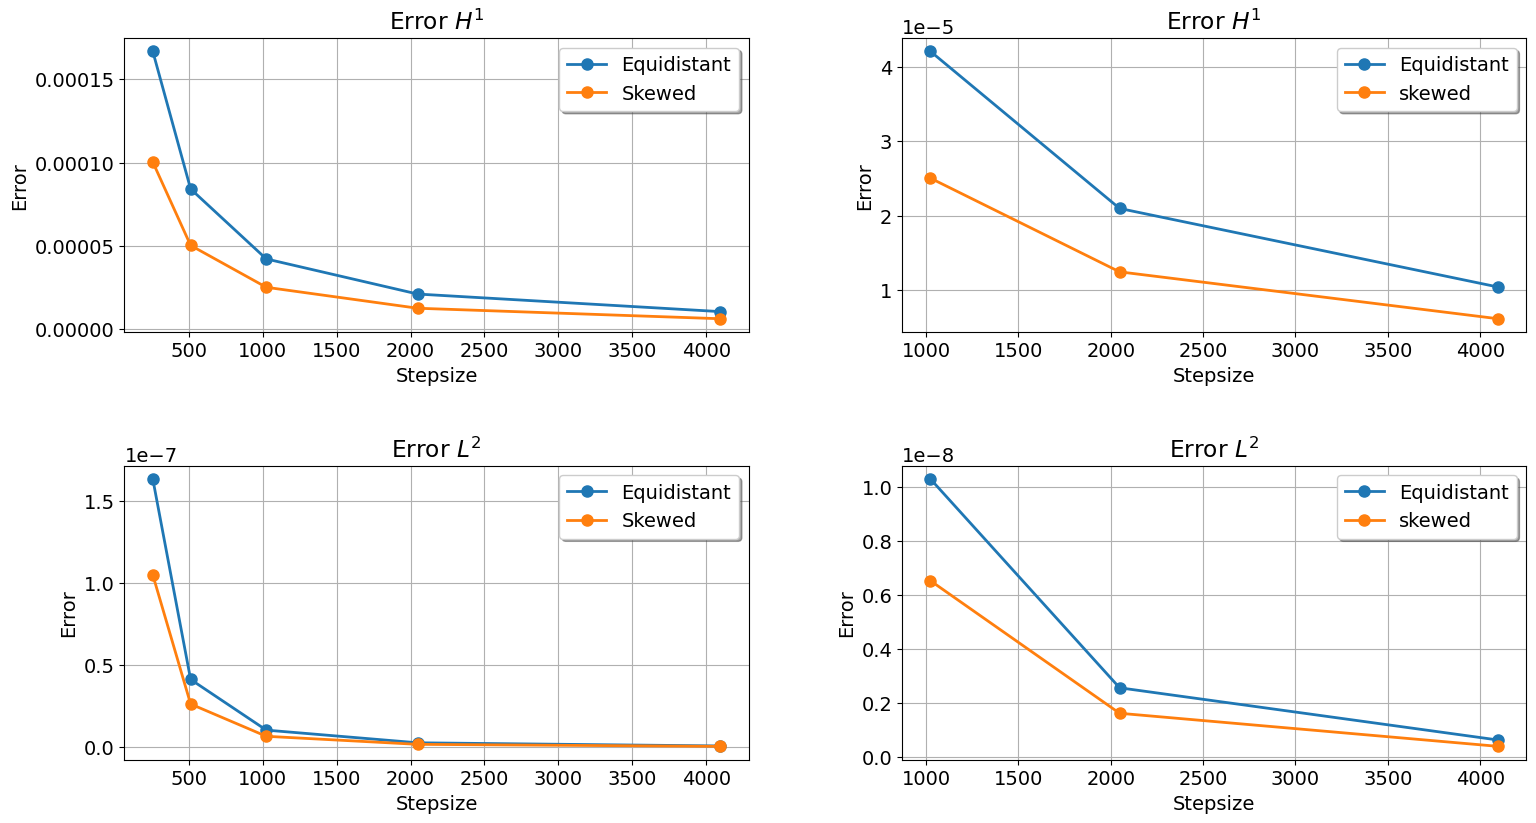

In [61]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

fig.tight_layout(h_pad=5, w_pad=5)

axs[0, 0].plot(N_5_H1, E_eq_5_H1, '-o', label = 'Equidistant')
axs[0, 0].plot(N_5_H1, E_sk_5_H1, '-o', label = 'Skewed')
axs[0, 0].set_title(r'Error $H^1$')
axs[0, 0].set_xlabel('Stepsize')
axs[0, 0].set_ylabel('Error')
axs[0, 0].legend(fancybox = True, shadow = True)

axs[0, 1].plot(N_3_H1, E_eq_3_H1, '-o', label = 'Equidistant')
axs[0, 1].plot(N_3_H1, E_sk_3_H1, '-o', label = 'skewed')
axs[0, 1].set_title(r'Error $H^1$')
axs[0, 1].set_xlabel('Stepsize')
axs[0, 1].set_ylabel(f'Error')
axs[0, 1].legend(fancybox = True, shadow = True)

axs[1, 0].plot(N_5_L2, E_eq_5_L2, '-o', label = 'Equidistant')
axs[1, 0].plot(N_5_L2, E_sk_5_L2, '-o', label = 'Skewed')
axs[1, 0].set_title(r'Error $L^2$')
axs[1, 0].set_xlabel('Stepsize')
axs[1, 0].set_ylabel('Error')
axs[1, 0].legend(fancybox = True, shadow = True)

axs[1, 1].plot(N_3_L2, E_eq_3_L2, '-o', label = 'Equidistant')
axs[1, 1].plot(N_3_L2, E_sk_3_L2, '-o', label = 'skewed')
axs[1, 1].set_title(r'Error $L^2$')
axs[1, 1].set_xlabel('Stepsize')
axs[1, 1].set_ylabel(f'Error')
axs[1, 1].legend(fancybox = True, shadow = True)

plt.show()